In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_path = '/kaggle/input/seg-data/'
train_path = os.path.join(base_path, 'seg_train')
test_path = os.path.join(base_path, 'seg_test')
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
target_size = (224, 224)
batch_szie = 32
num_classes = len(classes)

In [3]:
def load_and_preprocess_images(directory, target_size=(224, 224), preprocess_func=None):
    images = []
    labels = []

    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        class_index = classes.index(class_name)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            img_array = img_to_array(img_resized) / 255.0

            # Pre-processing
            if preprocess_func:
                img_array = preprocess_func(img_array)

            images.append(img_array)
            labels.append(class_index)

    return np.array(images), np.array(labels)

def compute_class_weights(labels):
    class_weights = dict(enumerate(
        compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    ))
    return class_weights

def create_dataset(directory, batch_size, image_size=(224, 224)):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        label_mode='categorical',
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True
    )
    return dataset

def preprocess_dataset(dataset, preprocess_func):
    def preprocess(image, label):
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = preprocess_func(image)  
        return image, label

    return dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
def create_data_generator(x_train, y_train):
    data_augmentation = Sequential([
        layers.Resizing(224, 224),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.6),
        layers.RandomZoom(0.3),
        layers.RandomContrast(0.3),
        layers.RandomTranslation(0.3, 0.3)
    ])
    
    # create dataset
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    
    # data augmentation
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    
    # batch
    dataset = dataset.batch(batch_szie).shuffle(1000).prefetch(tf.data.AUTOTUNE)
    
    return dataset

def create_transfer_learning_model(base_model, num_classes):
    # freeze
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
    
def train_model_with_generators(base_model_func, preprocess_func, model_name, batch_size=32):
    # load data
    train_dataset = create_dataset(train_path, batch_size)
    test_dataset = create_dataset(test_path, batch_size)

    # split data
    val_size = int(0.2 * len(train_dataset))
    train_dataset = train_dataset.skip(val_size)
    val_dataset = train_dataset.take(val_size)

    # pre-processing
    train_dataset = preprocess_dataset(train_dataset, preprocess_func)
    val_dataset = preprocess_dataset(val_dataset, preprocess_func)
    test_dataset = preprocess_dataset(test_dataset, preprocess_func)

    # data augmentation
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.6),
        layers.RandomZoom(0.3),
        layers.RandomContrast(0.3),
        layers.RandomTranslation(0.3, 0.3)
    ])
    train_dataset = train_dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    base_model = base_model_func(
        weights='imagenet', 
        include_top=False, 
        input_shape=(*target_size, 3)
    )

    model = create_transfer_learning_model(base_model, num_classes)

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', save_best_only=True, monitor='val_accuracy')

    # training
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[early_stopping, model_checkpoint]
    )

    # eval
    test_loss, test_accuracy = model.evaluate(test_dataset)
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.concatenate([np.argmax(y, axis=1) for _, y in test_dataset])
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_classes, y_pred_classes, average='weighted'
    )
    auc = roc_auc_score(y_test_classes, y_pred, multi_class='ovr', average='macro')
    
    return {
        'model': model,
        'history': history.history,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }
    
def plot_training_history(histories, model_names):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history['accuracy'], label=f'{name} Training')
        plt.plot(history['val_accuracy'], label=f'{name} Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history['loss'], label=f'{name} Training')
        plt.plot(history['val_loss'], label=f'{name} Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
x_train, y_train = load_and_preprocess_images(train_path)
x_test, y_test = load_and_preprocess_images(test_path)

y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_encoded, test_size=0.2, stratify=y_train
)

In [5]:
models = [
    (EfficientNetB0, efficientnet_preprocess, 'EfficientNetB0'),
    (VGG16, vgg16_preprocess, 'VGG16'),
    (ResNet50, resnet_preprocess, 'ResNet50'),
    (ResNet101, resnet_preprocess, 'ResNet101')
]

results = {}
histories = []

In [6]:
for base_model_func, preprocess_func, model_name in models:
    print(f"{model_name} Training...")
    result = train_model_with_generators(
        base_model_func=base_model_func,
        preprocess_func=preprocess_func,
        model_name=model_name
    )
    results[model_name] = result
    histories.append(result['history'])

EfficientNetB0 Training...
Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


I0000 00:00:1734318012.873523      67 service.cc:145] XLA service 0x7eb614029330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734318012.873633      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734318012.874084      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.2552 - loss: 6.4165 

I0000 00:00:1734318036.328681      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 ━━━━━━━━━━━━━━━━━━━━ 147s 312ms/step - accuracy: 0.7058 - loss: 3.8294 - val_accuracy: 0.8538 - val_loss: 1.2178
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.7787 - loss: 1.2563 - val_accuracy: 0.8531 - val_loss: 0.7367
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 236ms/step - accuracy: 0.7853 - loss: 0.8807 - val_accuracy: 0.8549 - val_loss: 0.6146
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 84s 232ms/step - accuracy: 0.7903 - loss: 0.7998 - val_accuracy: 0.8319 - val_loss: 0.6288
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 236ms/step - accuracy: 0.7894 - loss: 0.7690 - val_accuracy: 0.8606 - val_loss: 0.5720
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 84s 234ms/step - accuracy: 0.8049 - loss: 0.7154 - val_accuracy: 0.8775 - val_loss: 0.5404
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 84s 233ms/step - accuracy: 0.8045 - loss: 0.7138 - val_accuracy: 0.8847 - val_loss: 0.5104
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 84s 234ms/step - accuracy: 0.8049 - loss: 0.70

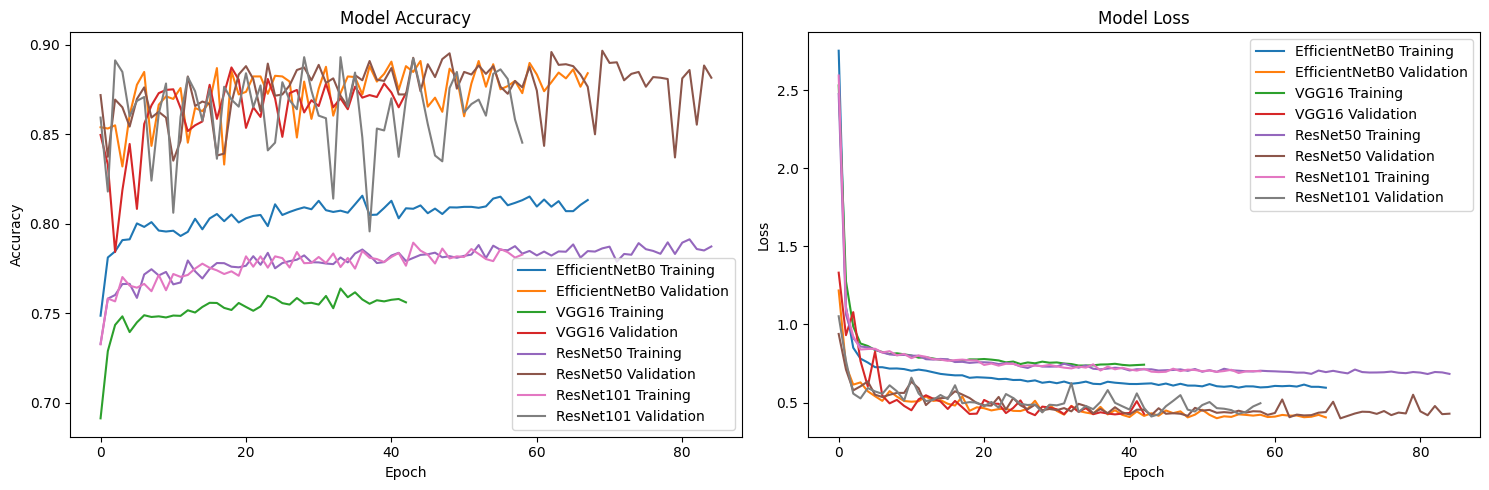

In [7]:
plot_training_history(histories, [model[2] for model in models])

In [8]:
for model_name, result in results.items():
    print(f"\n{model_name} Performance:")
    print(f"Test Loss: {result['test_loss']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1_score']:.4f}")
    print(f"AUC: {result['auc']:.4f}")


EfficientNetB0 Performance:
Test Loss: 0.4236
Test Accuracy: 0.8810
Precision: 0.1683
Recall: 0.1680
F1 Score: 0.1679
AUC: 0.5004

VGG16 Performance:
Test Loss: 0.4951
Test Accuracy: 0.8477
Precision: 0.1556
Recall: 0.1573
F1 Score: 0.1553
AUC: 0.4912

ResNet50 Performance:
Test Loss: 0.4207
Test Accuracy: 0.8883
Precision: 0.1612
Recall: 0.1613
F1 Score: 0.1609
AUC: 0.4988

ResNet101 Performance:
Test Loss: 0.4283
Test Accuracy: 0.8837
Precision: 0.1820
Recall: 0.1823
F1 Score: 0.1820
AUC: 0.5115


## Observation
Based on previous model training results [Figure 1], we can make the following observations:
1. EfficientNetB0
    - Validation accuracy improves steadily until around epoch 10-15, after which the improvements show down slowly. Validation loss fluctuates, with noticable improvements up to epoch 22-25. Beyond that, it shows minimal improvement or starts to degrade sligtly.
    - Training accuracy and loss continue to improve, but validation metrics stabilize or worsen slightly after epoch 25-35, indicating overfitting.
    - Based on the trends, a good stopping point would be around epoch 30.
2. VGG16
   - After epoch 10, the training accuracy has gap between validation set. Loss decreases continuosly, but validation loss fluctuates more. After epoch 50, validation performs slowly, overfitting is observed.
3. ResNet50
   - Validation loss improves early until epoch 20, but increases inconsistently in later epochs after 20.
   - Validation accuracy increases in early epochs, but plateaus and sometimes drops in later epochs.
4. ResNet101
   - From around epoch 25, the progress slows down gradually.
   - Validation loss initially fluctuates but shows noticable improvements through epochs 1-22, after which it stabilize and experiences minor fluctuations without major improvements.
   - Training accuracy and loss continue to show improvements throughout, but validation metrics stabilize or slightly worsen round epoch 30, indicating overfitting.
   - Based on the trends in both accuracy and loss, a good stopping point would be around 30, when validation shows diminishing returns.

## Conclusion
Among the four models, ```ResNet101``` emerges as the best-performing model. While ResNet50 achieves the lowest test loss and highest accuracy, ResNet101 delivers superior precision, recall, F1 score, and AUC, which are critical in multi-class classification tasks. The AUC of ResNet101 suggests it is slightly better at distinguishing between classes compared to the other models. Therefore, ResNet101 is the most suitable model for this problem.

In summary, ResNet101's improved balance across multiple metrics makes it the most reliable choice despite marginal differences in accuracy or loss.

## Figure 1
### EfficientNetB0
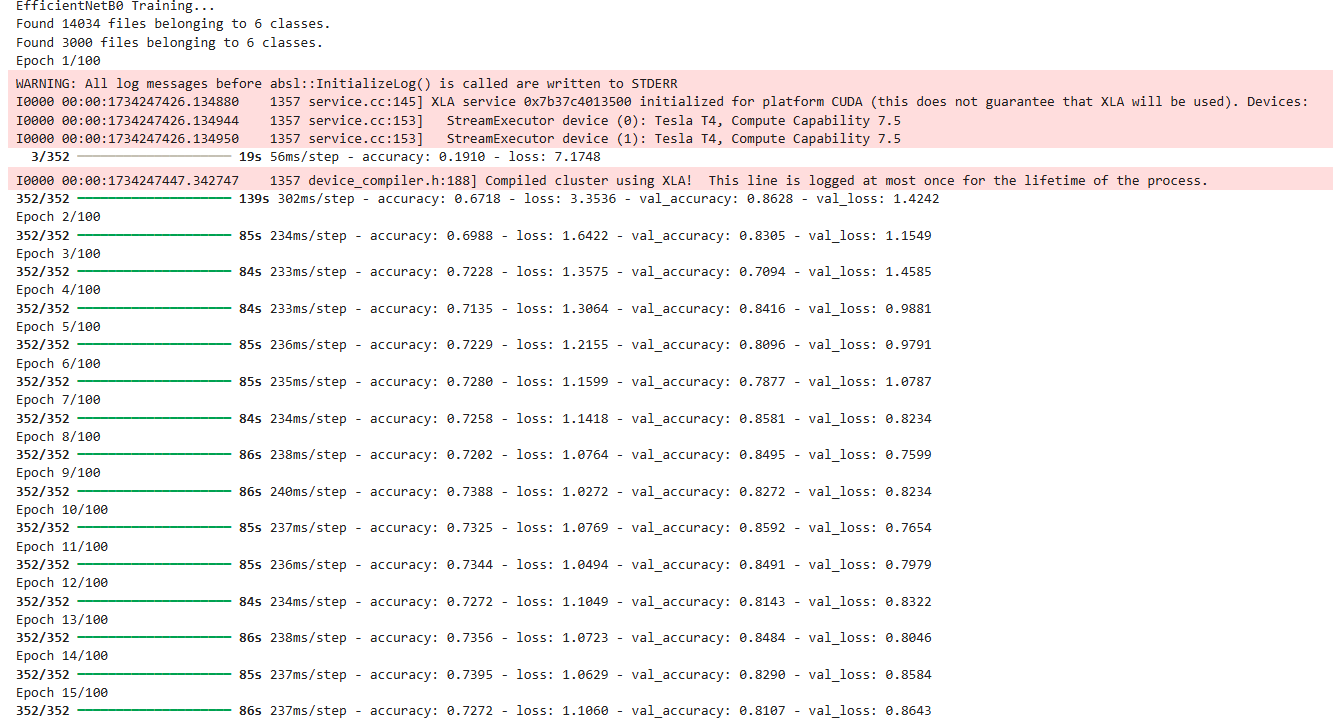
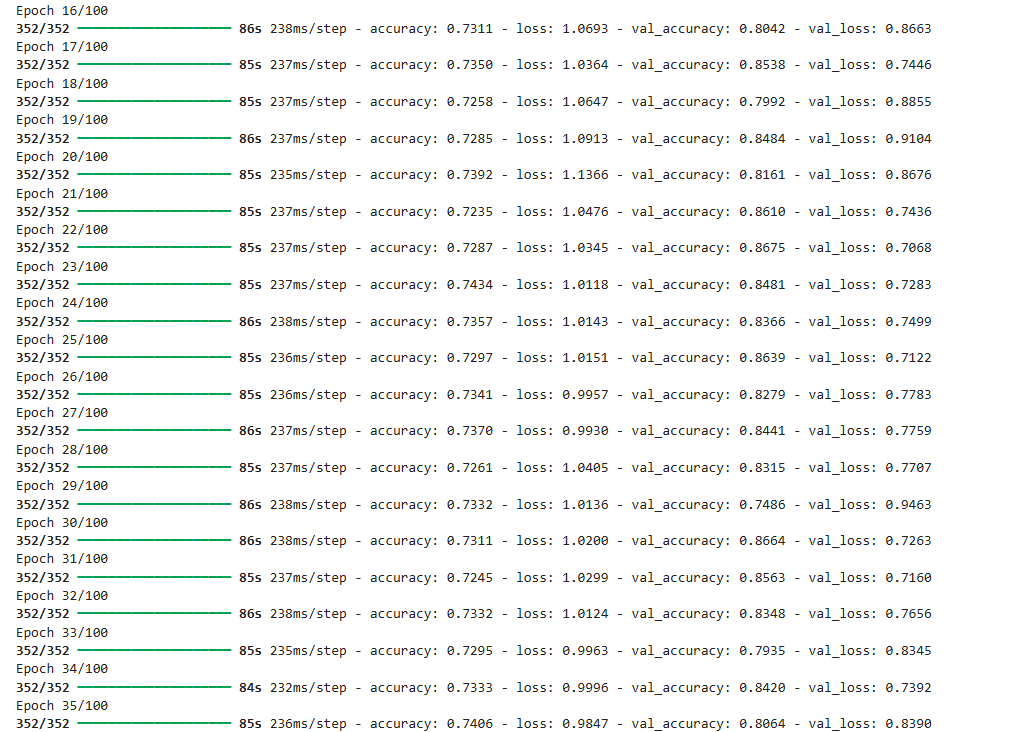
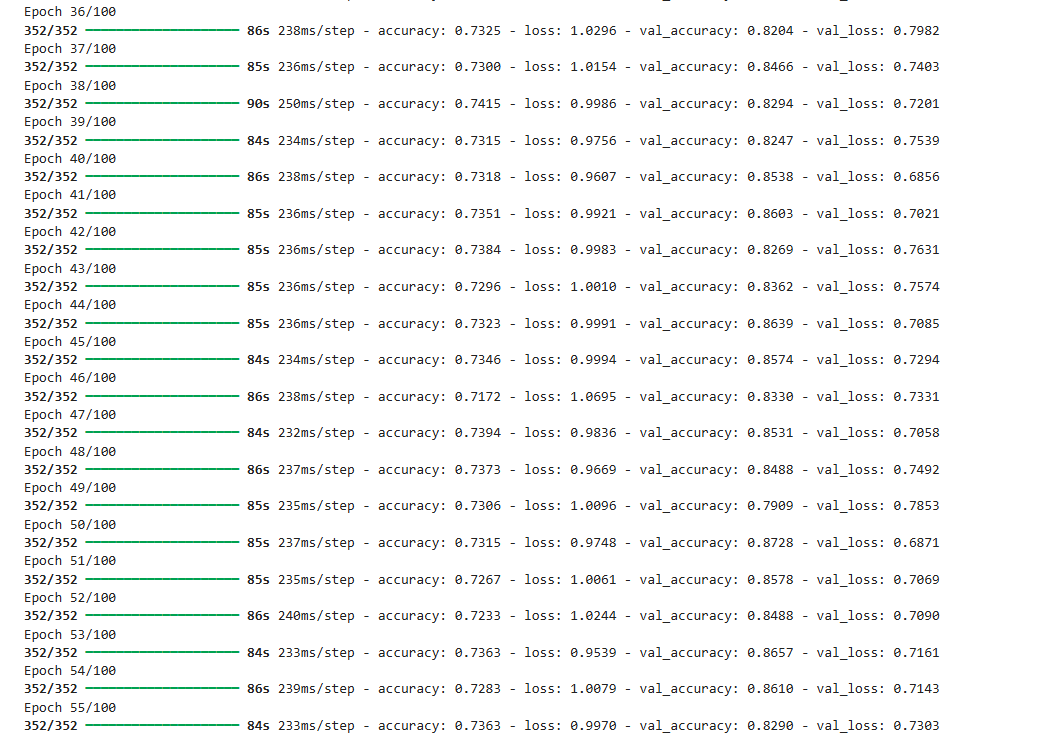
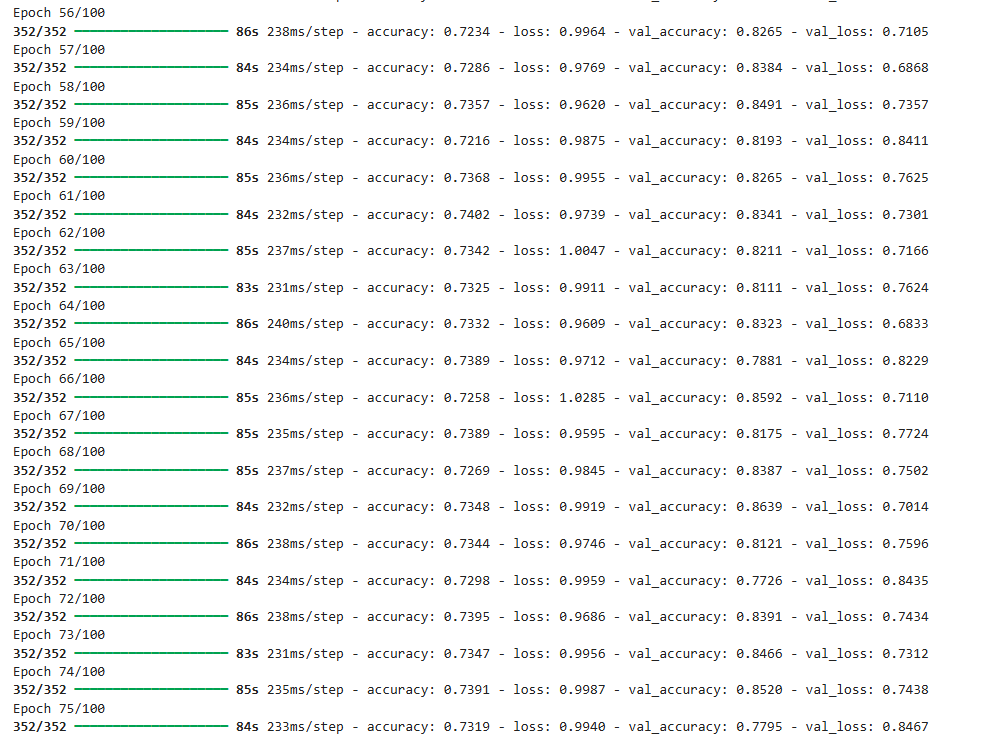
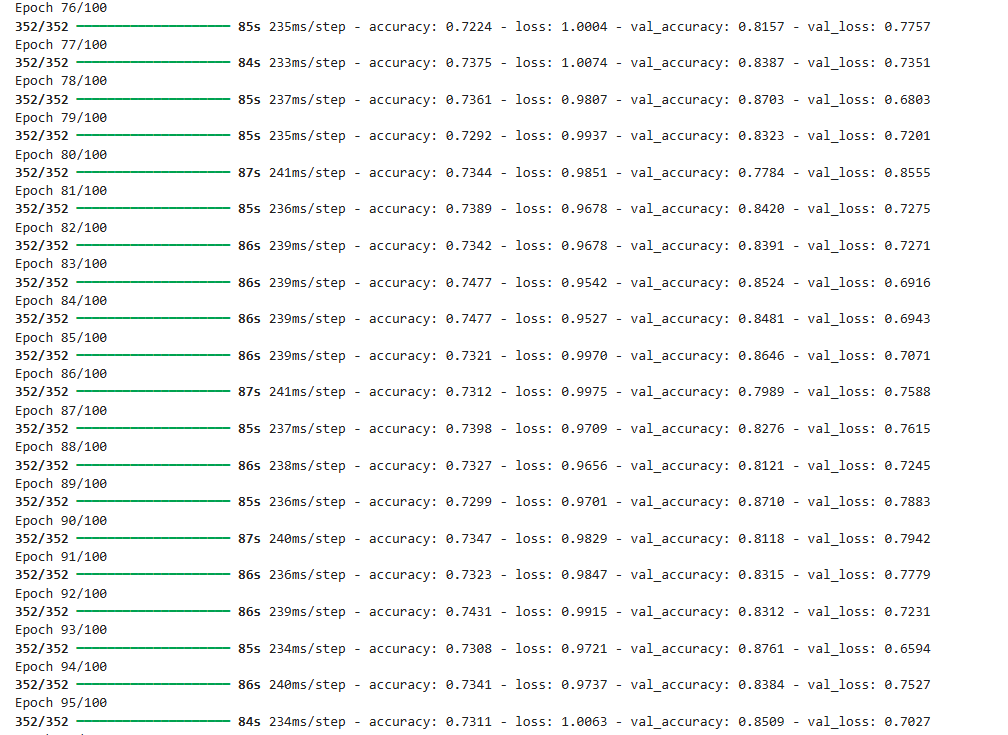
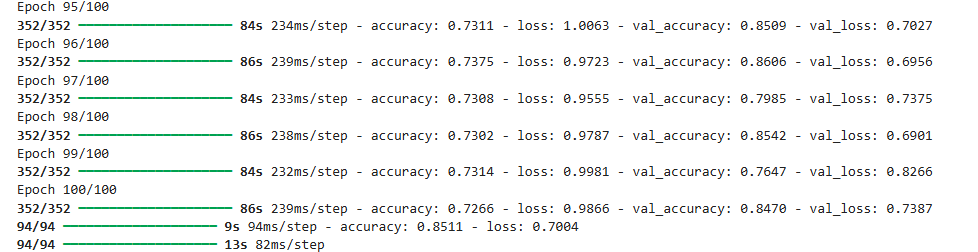

### VGG16
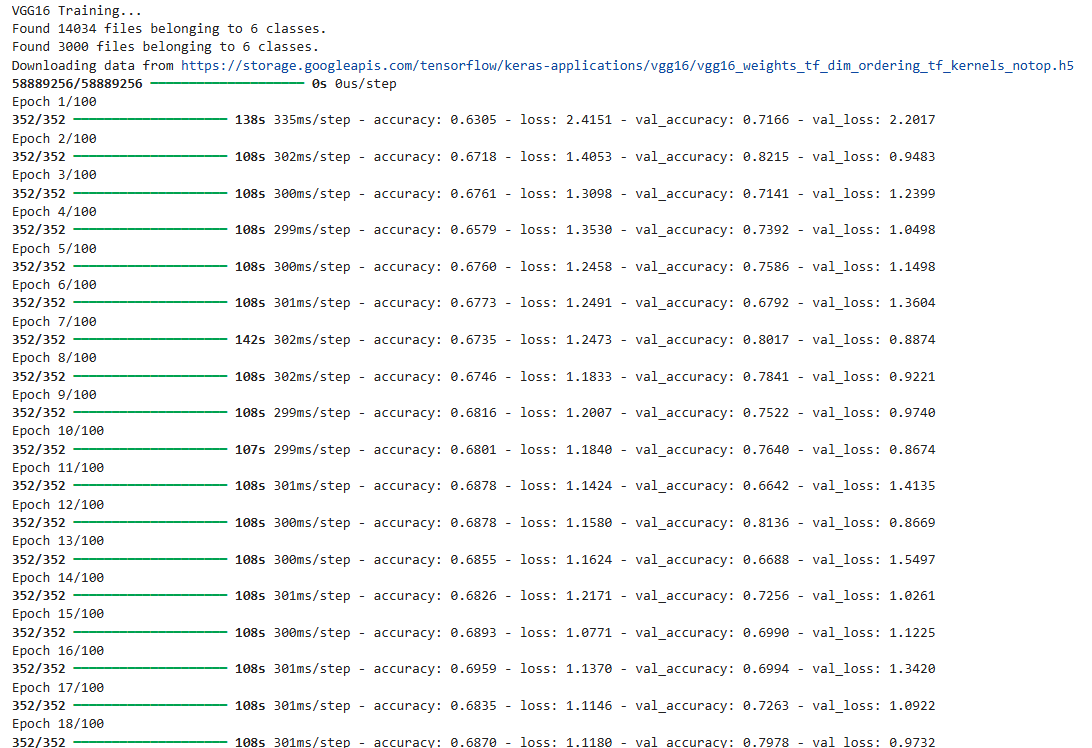
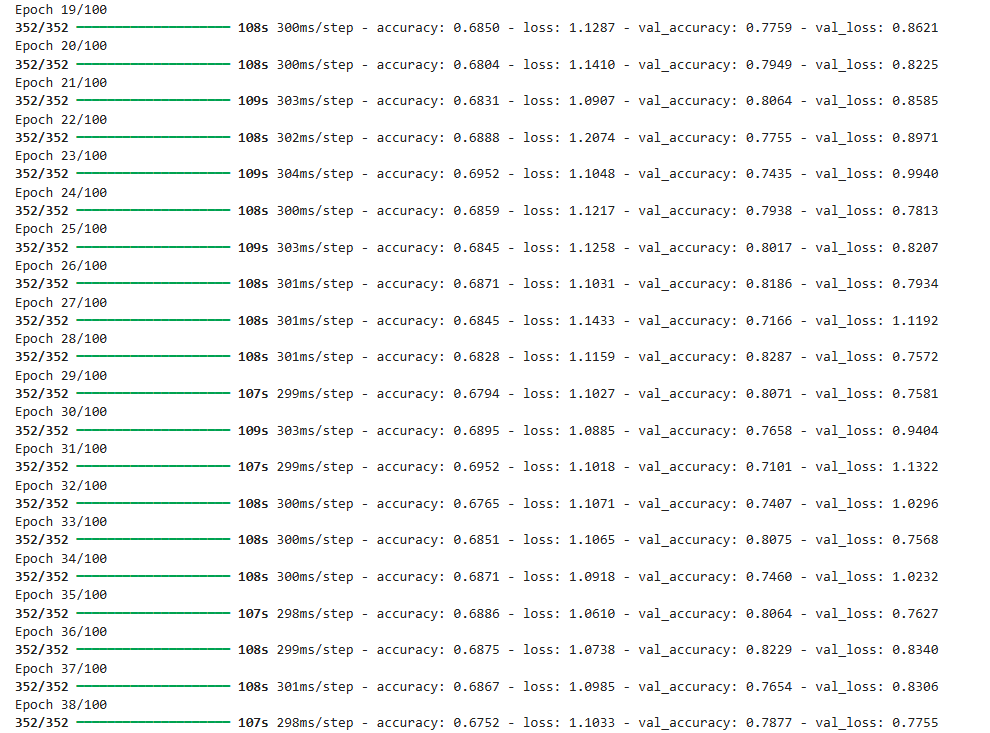
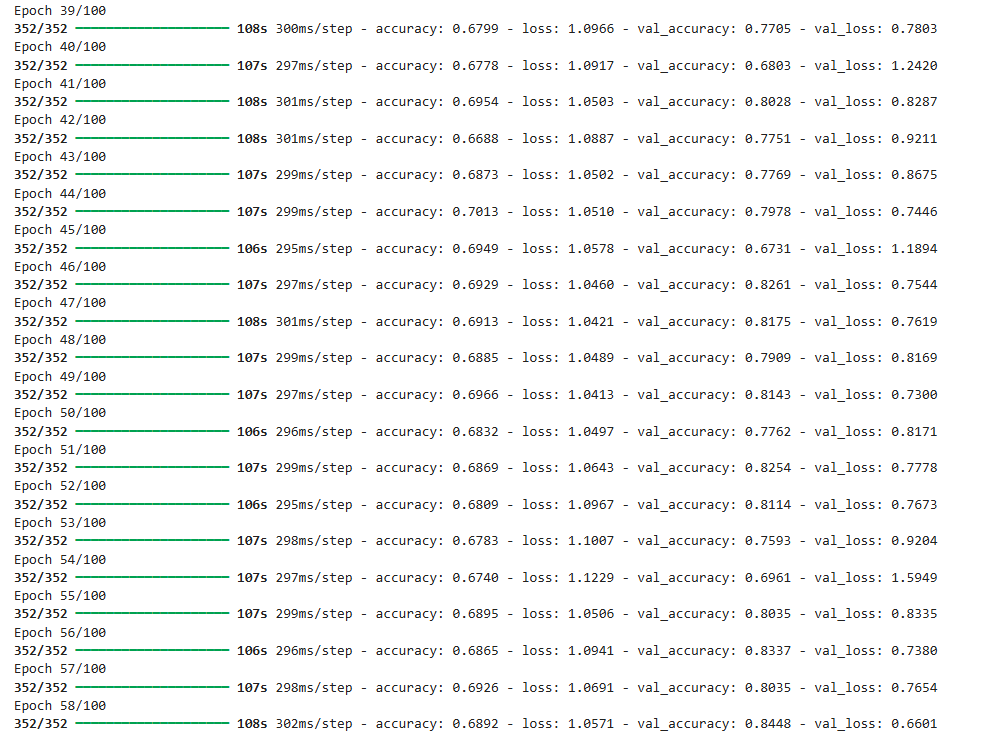
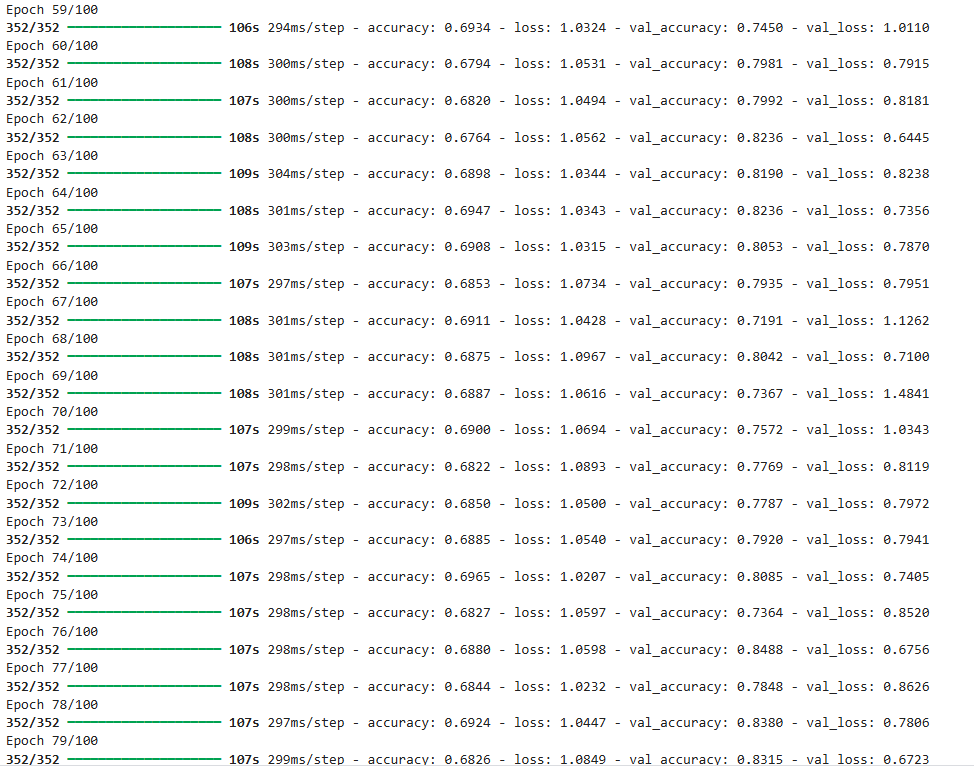
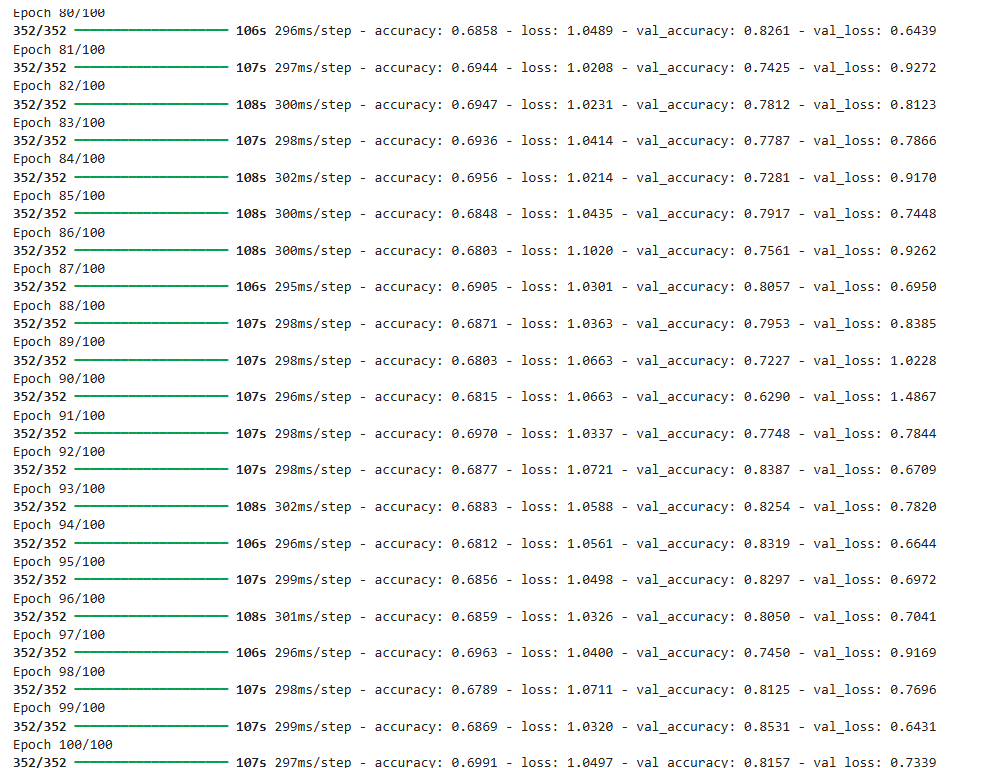

### ResNet50
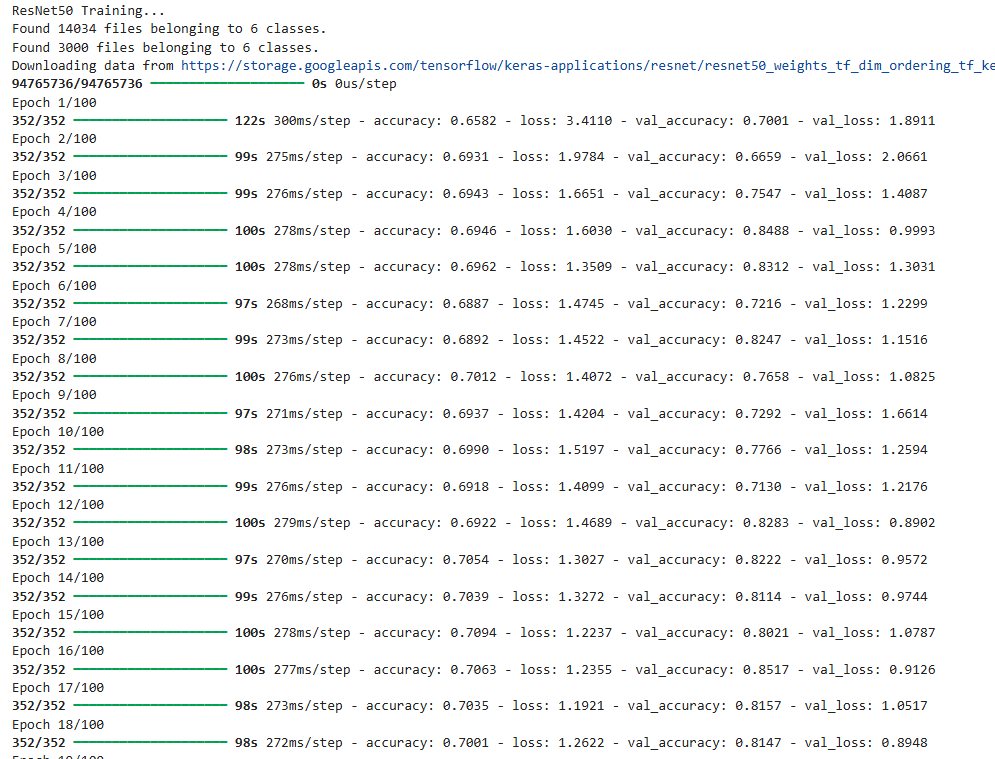
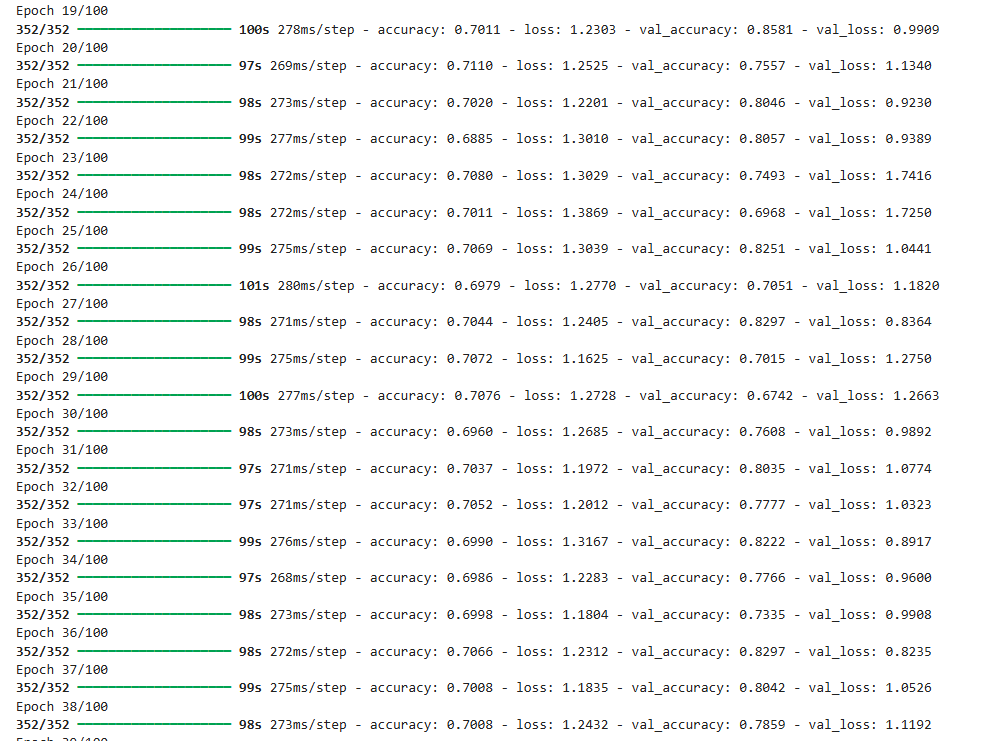
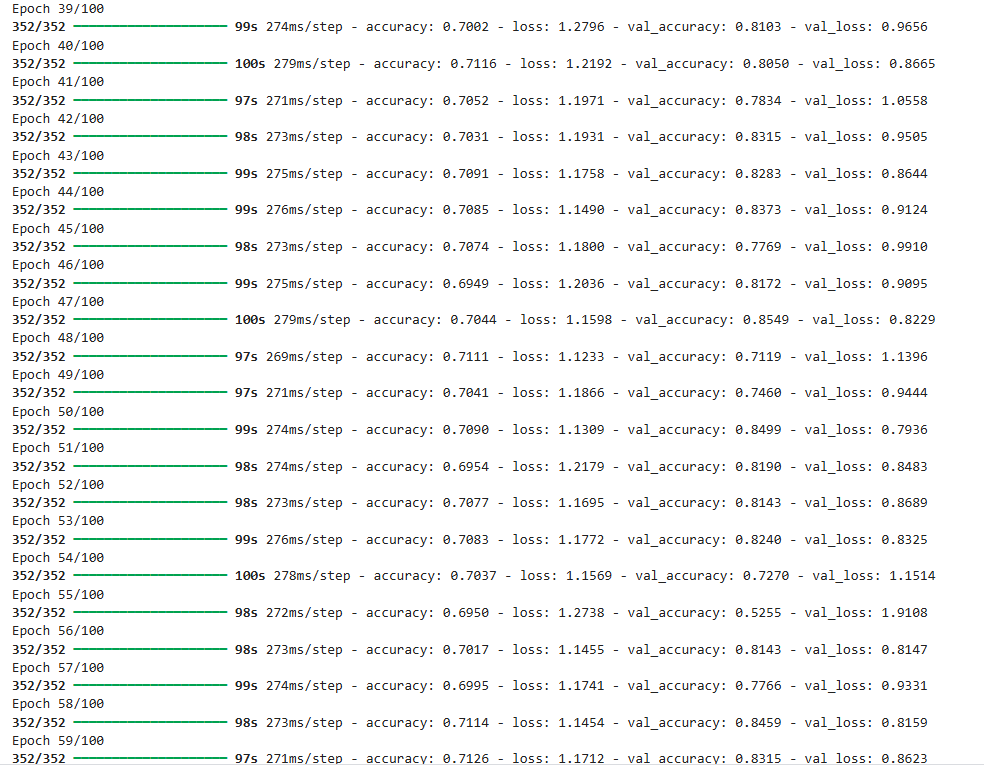
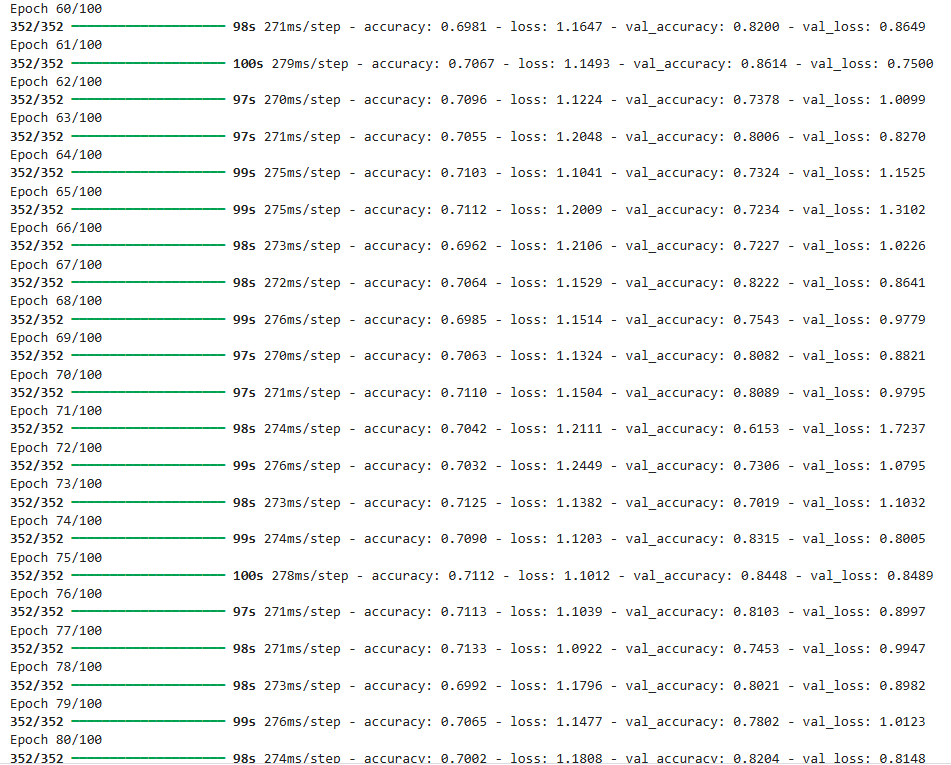
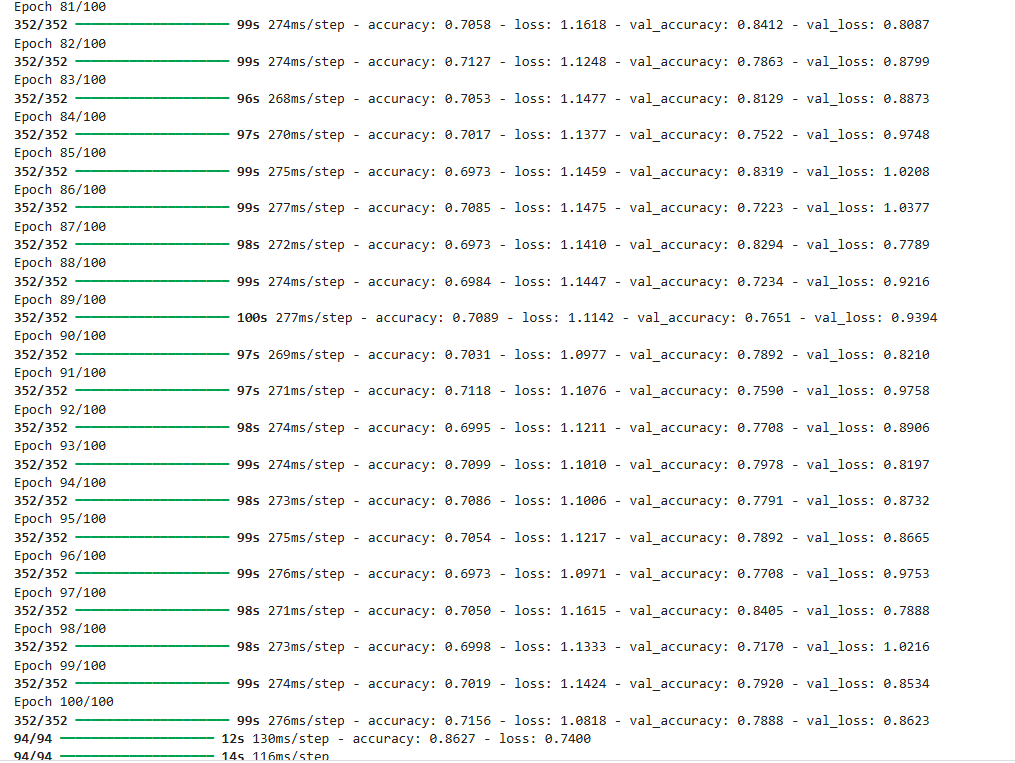

### ResNet101
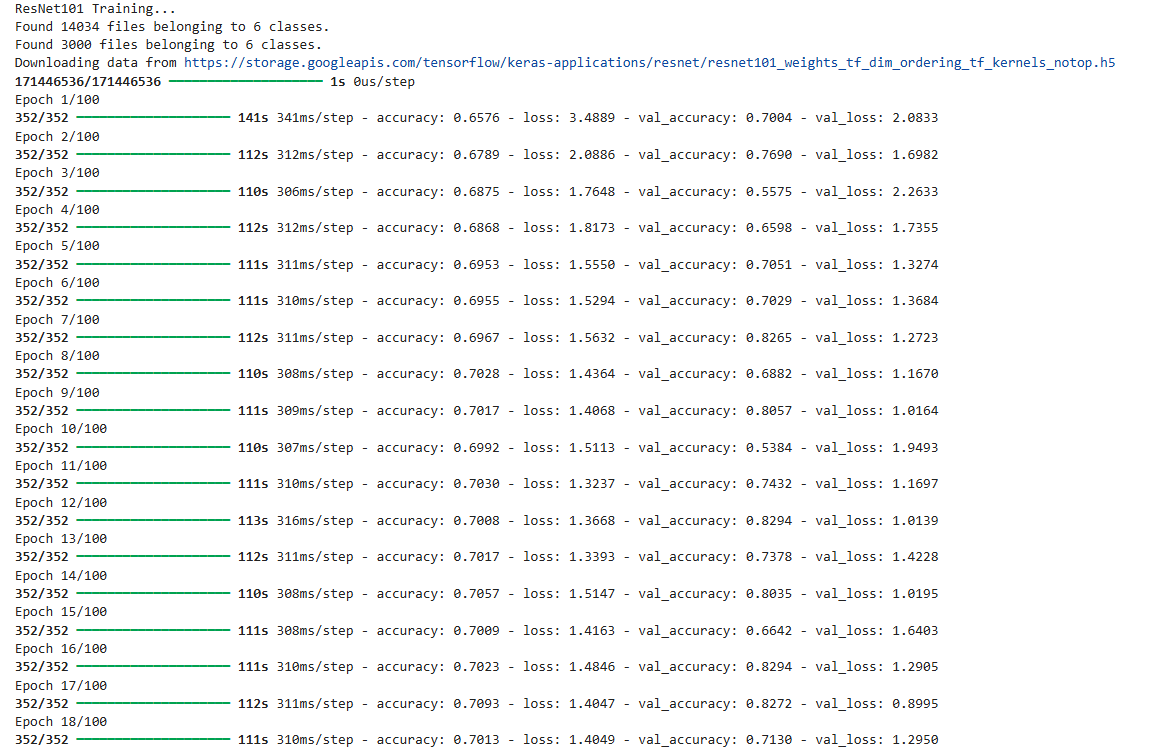
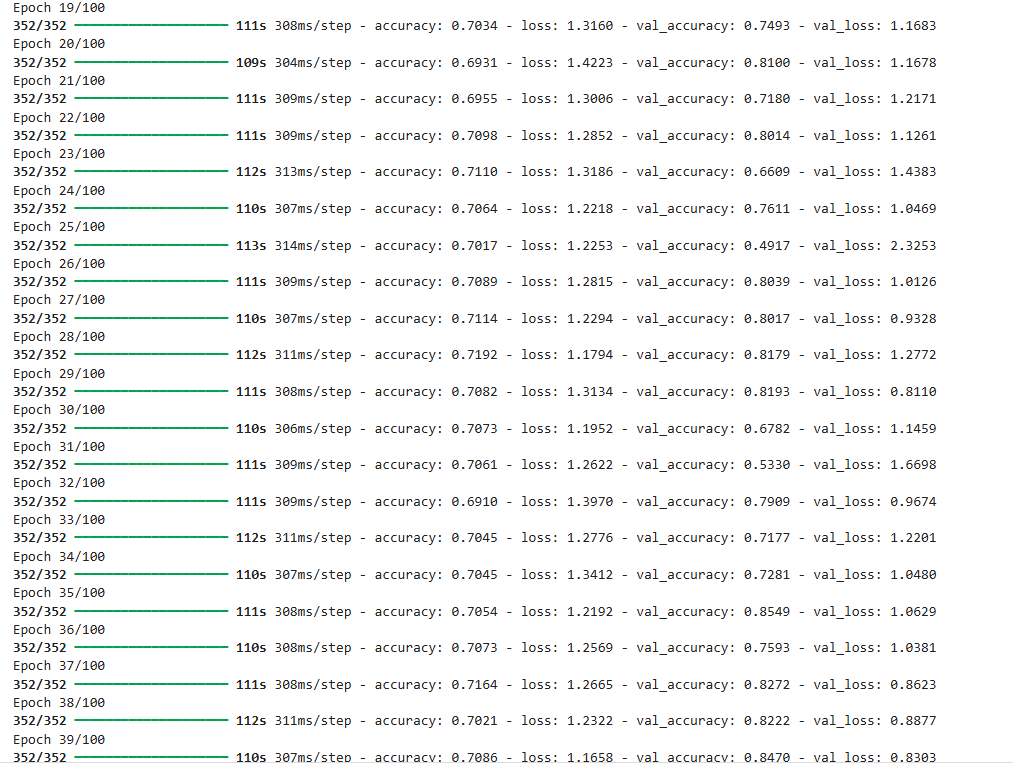
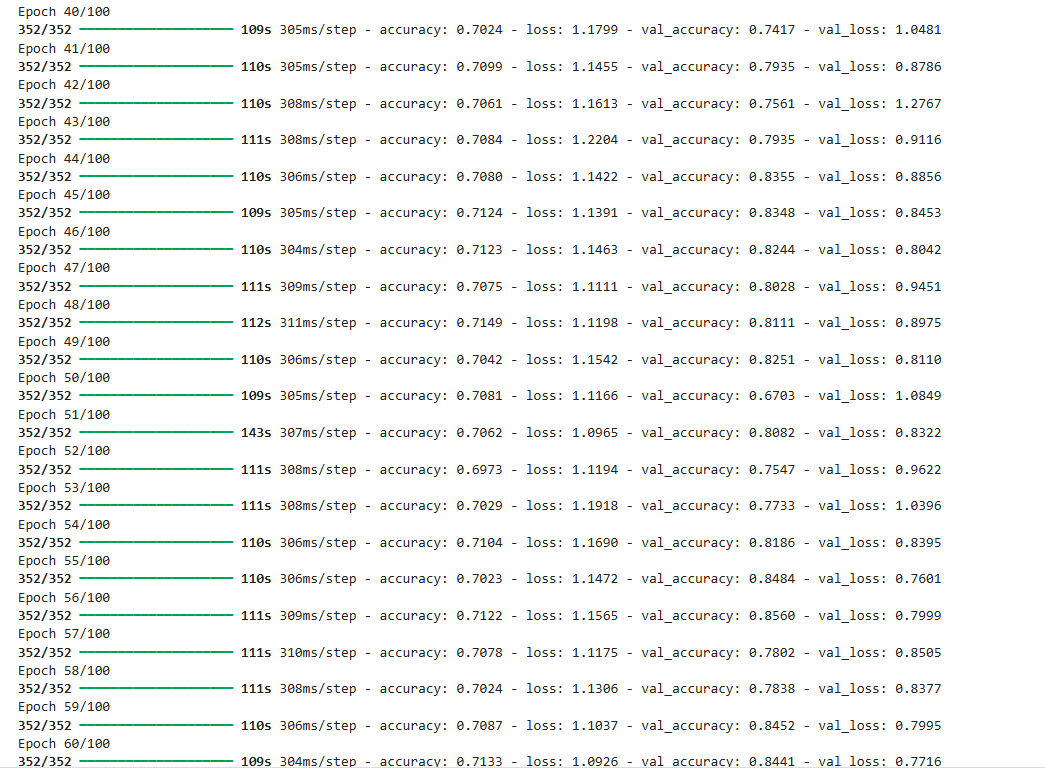

## Reference
- https://www.mathworks.com/help/deeplearning/ref/resnet101.html
- https://keras.io/api/applications/efficientnet/
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- https://keras.io/api/applications/vgg/
- https://www.geeksforgeeks.org/vgg-16-cnn-model/